In [ ]:
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import nltk
from nltk.corpus import stopwords
from  nltk.stem import WordNetLemmatizer

import gensim

import re
import numpy as np
from collections import Counter
import time
import pickle
import itertools


ImportError: cannot import name 'ExecutableLocation' from 'tensorflow.python.distribute.cluster_resolver.kubernetes_cluster_resolver' (c:\Users\Salma\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\distribute\cluster_resolver\kubernetes_cluster_resolver.py)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Salma\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [21]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Salma\AppData\Roaming\nltk_data...


True

## Read Dataset

In [4]:
df=pd.read_csv("dataset.csv",encoding="ISO-8859-1",names=["target", "ids", "date", "flag", "user", "text"])
#iso encoding used when data includes accented characters 

print("Dataset size:", len(df))

Dataset size: 1600000


In [6]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


the column target has 3 different values 0,2,4 --> we are going to label them as strings \
0 -> Negative \
2 -> Neutral \
4 -> Positive 

In [7]:
decode_map = {0:"Negative", 2:"Neutral", 4:"Positive"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [11]:
%%time 
#to measure how long the cell takes to run
df.target= df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 188 ms
Wall time: 313 ms


Counter({'Negative': 800000, 'Positive': 800000})


Text(0.5, 1.0, 'Dataset labels distribution')

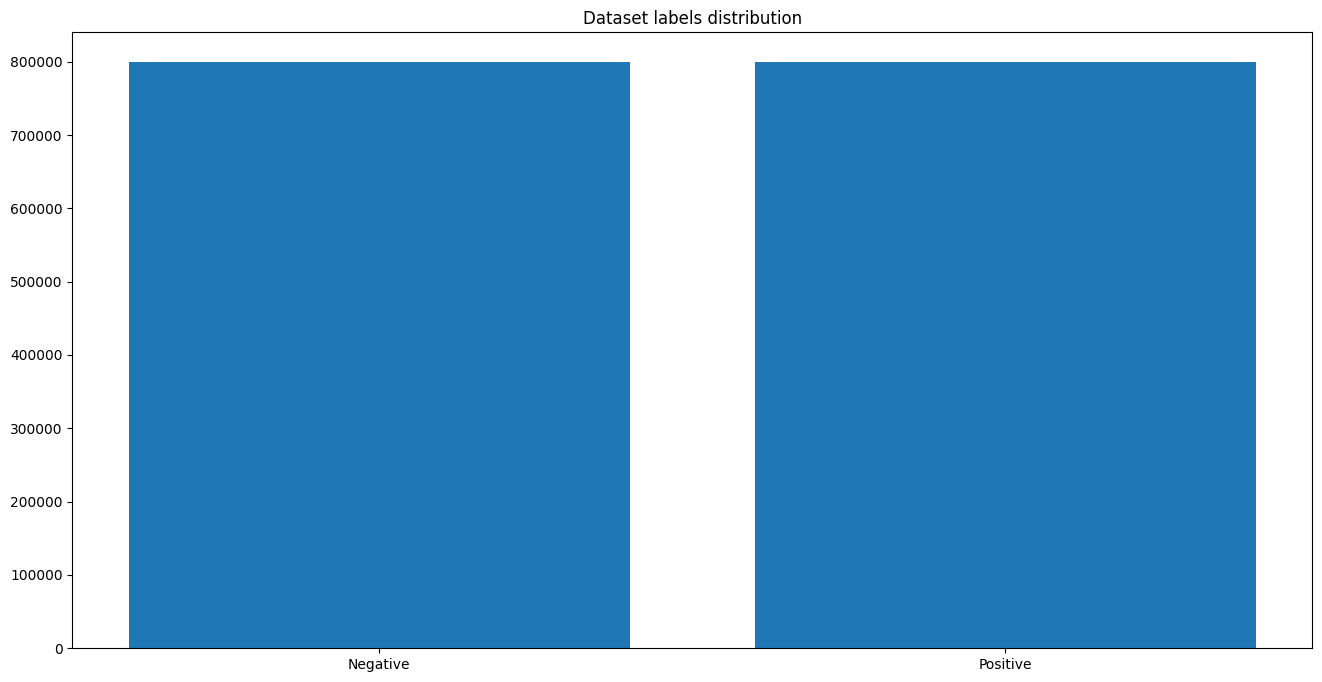

In [12]:
target_cnt=Counter(df.target)
print(target_cnt)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(),target_cnt.values())
plt.title("Dataset labels distribution")

## Preprocessing Dataset

In [ ]:
stopwords= stopwords.words("english")
lm= WordNetLemmatizer()

re.sub(pattern,replacement,string) it is **a regular expression substitution function** will replace all occurences of the pattern 

In [23]:
def preprocess(text):
    #remove links,mentions of user and special characters with regex
    text= re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+",' ', str(text).lower()).strip()
    tokens=[]
    for token in text.split():
        if token not in stopwords:
            tokens.append(lm.lemmatize(token))
    return " ".join(tokens)

<>:3: SyntaxWarning: invalid escape sequence '\S'
<>:3: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Salma\AppData\Local\Temp\ipykernel_25948\761145634.py:3: SyntaxWarning: invalid escape sequence '\S'
  text= re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+",' ', str(text).lower()).strip()


In [24]:
%%time
df.text= df.text.apply(lambda x: preprocess(x))

CPU times: total: 26.5 s
Wall time: 1min 42s


## Split train and test

In [25]:
df_train,df_test =train_test_split(df, test_size=0.2,random_state=42)
print("Train size", len(df_train))
print("Test size", len(df_test))

Train size 1280000
Test size 320000


## Word2Vec

In [26]:
documents= [ _text.split() for _text in df_train.text]

In [29]:
w2v_model= gensim.models.word2vec.Word2Vec(vector_size=300, window=7, epochs=32, min_count=10, workers=8)
#each word will be represented as a 300-dimensional vector
#context window size is 7 so it will consider 7 words before and 7 words after as context
#epochs number of training iterations
#min count words that appear less than 10 times in the corpus will be ignored --> to reduce noise 
#workers number of parallel threads to train model


In [30]:
w2v_model.build_vocab(documents)

In [33]:
words = list(w2v_model.wv.index_to_key) #all the words that the w2v model has learned embeddings for 
vocab_size= len(words)
print("Vocab size", vocab_size)

Vocab size 27470


In [34]:
w2v_model.train(documents,total_examples=len(documents),epochs=32)

(261893461, 295270528)

In [ ]:
w2v_model.wv.most_similar("love")
#similarity score is calculated using cosine similarity 

[('luv', 0.5641544461250305),
 ('loved', 0.5499627590179443),
 ('amazing', 0.5294432640075684),
 ('adore', 0.5022823214530945),
 ('looove', 0.48321428894996643),
 ('awesome', 0.4601105749607086),
 ('lovee', 0.4437020421028137),
 ('loving', 0.43209677934646606),
 ('loveee', 0.4315391182899475),
 ('miss', 0.4291265308856964)]

## Tokenize text

In [37]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size=len(tokenizer.word_index) +1
print("Total words", vocab_size)

Total words 279336


Example : \
text = "I love twitter"\
tokenizer.word_index = {"i": 1, "love": 2, "twitter": 3}\
sequence = tokenizer.texts_to_sequences([text])\
print(sequence)  # [[1, 2, 3]]

In [38]:

x_train=pad_sequences(tokenizer.texts_to_sequences(df_train.text),maxlen=300) #maxlen so all inputs have the same length
x_test= pad_sequences(tokenizer.texts_to_sequences(df_test.text),maxlen=300)

## Label Encoder 

In [41]:
labels= df_train.target.unique().tolist()
labels.append("Neutral")
print(labels)

['Positive', 'Negative', 'Neutral']


In [42]:
encoder= LabelEncoder()
encoder.fit(df_train.target.tolist()) #encoder learns a mapping from each unique label 

y_train= encoder.transform(df_train.target.tolist()) #transform all the training labels to numeric int based on the mapping learned
y_test= encoder.transform(df_test.target.tolist())

y_train= y_train.reshape(-1,1) #convert vector from 1D to 2D
y_test= y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [43]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


## Embedding layer 

In [ ]:
embedding_matrix = np.zeros((vocab_size,300)) #initially all embeddings 0

#filling the embedding matrix with word vectors 
for word, i in tokenizer.word_index.items(): 
    if word in w2v_model.wv:
        embedding_matrix[i]= w2v_model.wv[word]

# words that are not in Word2Vec remain zeroes
print(embedding_matrix.shape)

(279336, 300)


In [46]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

c:\Users\Salma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.


## Build Model

In [49]:
# we are creating a neural network 
model= Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5)) # to prevent overfitting 50% of neurons will be randomly dropped during training in this layer 
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) #lstm to capture word order and context 
model.add(Dense(1, activation='sigmoid')) # fully connected layer --> output : probability of positive class 

model.build(input_shape=(None, 300))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 300)       │    83,800,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 300, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,961,301 (320.29 MB)

 Trainable params: 160,501 (626.96 KB)

 Non-trainable params: 83,800,800 (319.67 MB)

## Compile Model

In [ ]:
model.compile(loss='binary_crossentropy', #binary because we have two classes 
              optimizer="adam",
              metrics=['accuracy'])

## Callbacks 
are used to optimize training : 
- reduce learning rate when model is stuck (wait 5 epochs before reducing)
- early stopping if model stops improving to prevent overfitting improvemement larger than min_delta are considered significant 


In [53]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5,mode=max)]

c:\Users\Salma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:77: UserWarning: EarlyStopping mode '<built-in function max>' is unknown, fallback to auto mode.


## Train

In [54]:
history= model.fit(x_train, y_train, batch_size=1024, epochs=8, validation_split=0.1, verbose=1, callbacks=callbacks)

Epoch 1/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1626s 1s/step - accuracy: 0.7661 - loss: 0.4813 - val_accuracy: 0.7833 - val_loss: 0.4584 - learning_rate: 0.0010
Epoch 2/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2055s 2s/step - accuracy: 0.7663 - loss: 0.4803 - val_accuracy: 0.7828 - val_loss: 0.4587 - learning_rate: 0.0010
Epoch 3/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2963s 3s/step - accuracy: 0.7685 - loss: 0.4776 - val_accuracy: 0.7858 - val_loss: 0.4546 - learning_rate: 0.0010
Epoch 4/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1846s 2s/step - accuracy: 0.7718 - loss: 0.4729 - val_accuracy: 0.7875 - val_loss: 0.4532 - learning_rate: 0.0010
Epoch 5/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1659s 1s/step - accuracy: 0.7731 - loss: 0.4707 - val_accuracy: 0.7882 - val_loss: 0.4516 - learning_rate: 0.0010
Epoch 6/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1854s 2s/step - accuracy: 0.7742 - loss: 0.4693 - val_accuracy: 0.7888 - val_loss: 0.4500 - learning_rate: 0.0010
Epoch 7/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3890s 3s/step - accuracy: 0.7

## Evaluation

In [55]:
score= model.evaluate(x_test, y_test, batch_size=1024)
print("ACCURACY", score[1])
print("LOSS", score[0])


313/313 ━━━━━━━━━━━━━━━━━━━━ 161s 512ms/step - accuracy: 0.7880 - loss: 0.4488
ACCURACY 0.7879906296730042
LOSS 0.4487701654434204


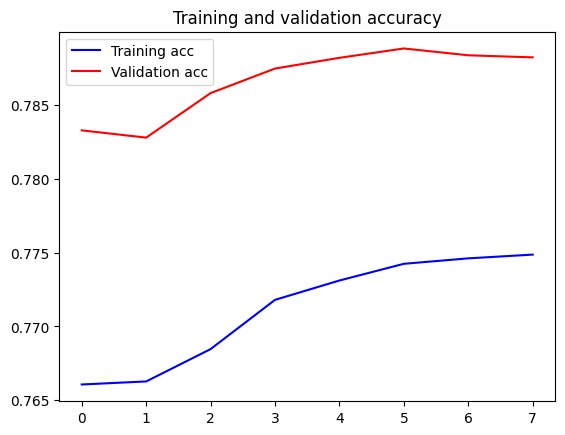

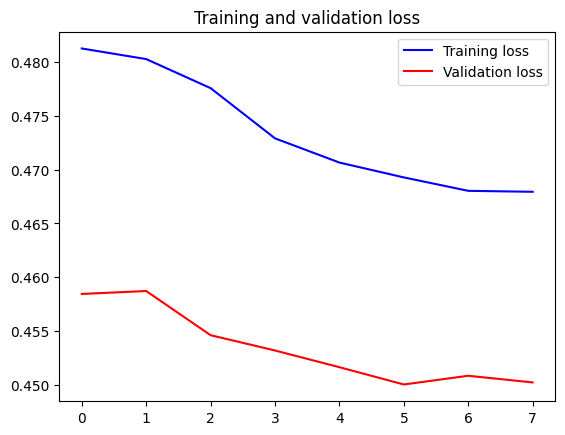

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## Prediction

In [59]:
def decode_sentiment (score ,include_neutral=True):
    if include_neutral:
        label= "Neutral"
        if score <= 0.4 : 
            label= "Negative"
        elif score >= 0.7:
            label= "Positive"
        return label
    else :
        return "Negative" if score< 0.5 else "Positive"

In [60]:
def predict(text, include_neutral=True):
    start_at= time.time()
    #tokenize text
    x_test=pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=300)
    #predict
    score= model.predict([x_test])[0]
    #decode sentiment
    label = decode_sentiment(score,include_neutral=include_neutral)
    return {"label": label, "score": float(score),"elapsed_time": time.time()-start_at} 

In [61]:
predict("I love Palestine")

c:\Users\Salma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(1, 300))',)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


C:\Users\Salma\AppData\Local\Temp\ipykernel_25948\4124210472.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),"elapsed_time": time.time()-start_at}


{'label': 'Positive',
 'score': 0.9337561130523682,
 'elapsed_time': 0.4738731384277344}

In [62]:
predict("die")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


C:\Users\Salma\AppData\Local\Temp\ipykernel_25948\4124210472.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),"elapsed_time": time.time()-start_at}


{'label': 'Negative',
 'score': 0.11918790638446808,
 'elapsed_time': 0.18727922439575195}

## Confusion Matrix 
to evaluate how well the model performs 

In [63]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step
CPU times: total: 21min 8s
Wall time: 4min 2s


In [64]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

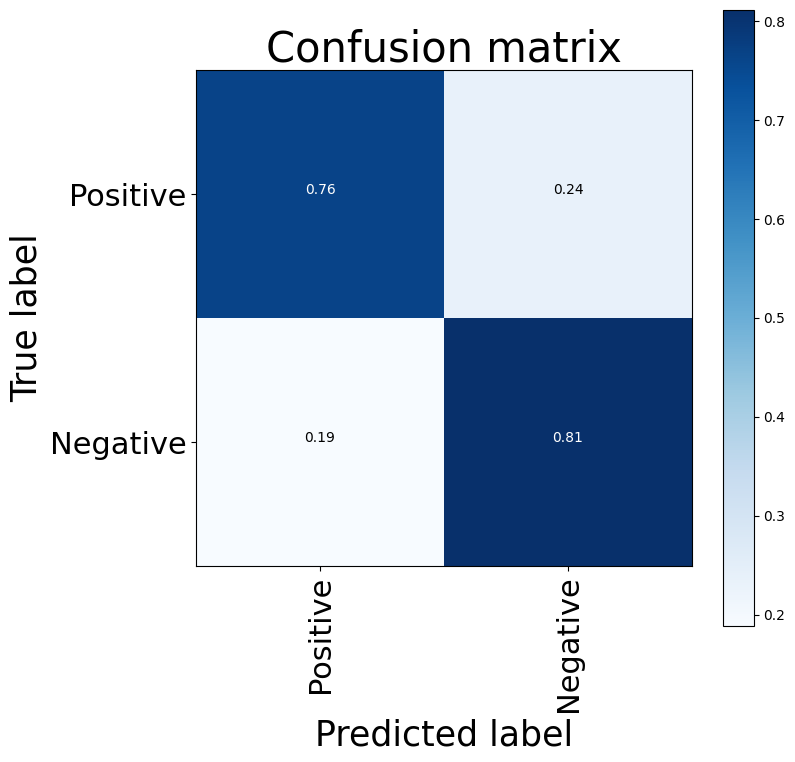

In [70]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

true positive 0.76 false negative 0.24 true negative 0.19 false negative 0.81 \
--> model slightly better at recognizing negatives than postives 

In [66]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.80      0.76      0.78    159494
    Positive       0.78      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [67]:
accuracy_score(y_test_1d, y_pred_1d)

0.787990625

In [71]:
model.save("model.h5")
w2v_model.save("model.w2v")
pickle.dump(tokenizer, open("tokenizer.pkl", "wb"), protocol=0)
pickle.dump(encoder, open("encoder.pkl", "wb"), protocol=0)